# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem

In [2]:
mesh = dl.IntervalMesh(100, -1.5, 1.5)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time",
    inference_type="drift_only",
    log_squared_diffusion=("std::log(std::pow(x[0],2) + 2)",),
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",), spin_problem.function_space_parameters
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)
data_stride = 5
data_locations = solution_coordinates[4:-5:data_stride]
data_values = true_solution[4:-5:data_stride]
rng = np.random.default_rng(seed=0)
noise_std = 0.01
noise = rng.normal(loc=0, scale=noise_std, size=data_values.size)
data_values = data_values + noise

right_hand_side = 0.1 * np.ones_like(true_solution)
true_adjoint = spin_problem.solve_adjoint(true_solution, true_parameter, right_hand_side)
true_gradient = spin_problem.evaluate_gradient(true_solution, true_parameter, right_hand_side)

Text(0, 0.5, '$g(x)$')

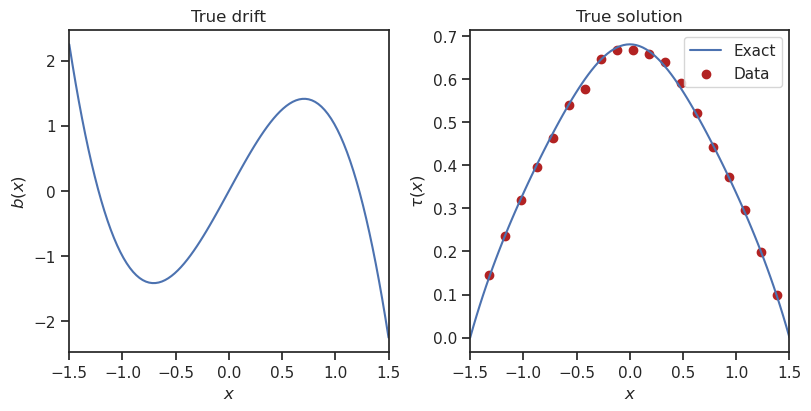

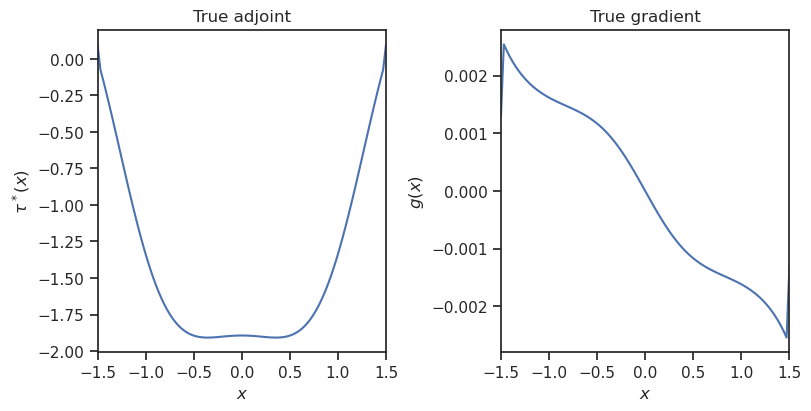

In [4]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_parameter)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[1].plot(solution_coordinates, true_solution, label="Exact")
axs[1].scatter(data_locations, data_values, color="firebrick", label="Data")
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True solution")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\tau(x)$")
axs[1].legend()

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(solution_coordinates, true_adjoint)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True adjoint")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$\tau^*(x)$")
axs[1].plot(parameter_coordinates, true_gradient)
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True gradient")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$g(x)$")

# Prior

In [5]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]",),
    variance=("1",),
    correlation_length=("1",),
    robin_bc=True,
    robin_bc_const=3.0
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=100
)
prior_gradient = spin_prior.evaluate_gradient(true_parameter)

(-1.5, 1.5)

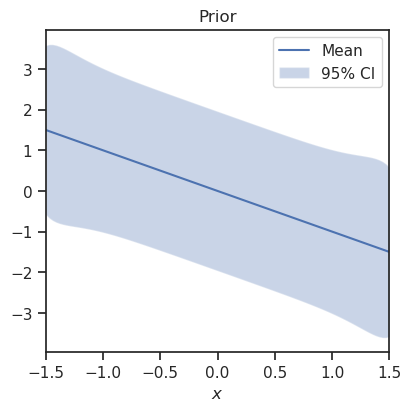

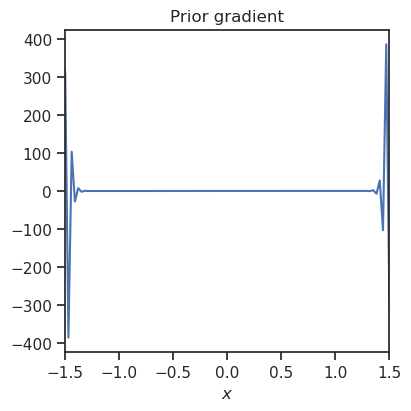

In [6]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, spin_prior.mean_array, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array - 1.96 * np.sqrt(prior_variance),
    spin_prior.mean_array + 1.96 * np.sqrt(prior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Prior")
ax.set_xlabel(r"$x$")
ax.set_xlim(-1.5, 1.5)
ax.legend()

_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, prior_gradient)
ax.set_title("Prior gradient")
ax.set_xlabel(r"$x$")
ax.set_xlim(-1.5, +1.5)

# Misfit

In [7]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=data_locations,
    observation_values=data_values,
    noise_variance=np.ones(data_locations.size) * noise_std**2,
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

discrepancy = data_values - spin_misfit.observation_matrix @ true_solution
misfit_grad = spin_misfit.observation_matrix.T @ spin_misfit.noise_precision_matrix @ discrepancy

Text(0.5, 0, '$x$')

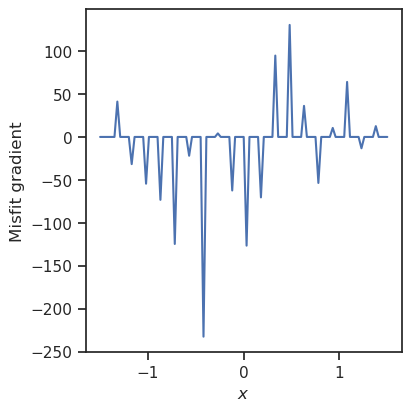

In [8]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(solution_coordinates, misfit_grad)
ax.set_ylabel("Misfit gradient")
ax.set_xlabel(r"$x$")

# Optimization

In [9]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

In [10]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-6, absolute_tolerance=1e-4, verbose=True
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.889616e+03    1.887812e+03    1.803933e+00   -5.170915e+04   3.219192e+04   1.000000e+00   5.000000e-01
  2   1    5.076705e+01    4.661511e+01    4.151942e+00   -3.753275e+03   4.502810e+03   1.000000e+00   3.739972e-01
  3   1    1.189700e+01    7.168961e+00    4.728040e+00   -7.779092e+01   4.729717e+02   1.000000e+00   1.212116e-01
  4   4    9.256516e+00    4.326960e+00    4.929556e+00   -5.257498e+00   3.392275e+01   1.000000e+00   3.246176e-02
  5   5    9.103538e+00    4.016698e+00    5.086840e+00   -3.082656e-01   6.164694e+00   1.000000e+00   1.383829e-02
  6   6    9.101899e+00    4.011858e+00    5.090041e+00   -3.276268e-03   7.549289e-01   1.000000e+00   4.842611e-03
Termination reason: Norm of the gradient less than tolerance


# Low-Rank Hessian

In [11]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=15,
    num_oversampling=5,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

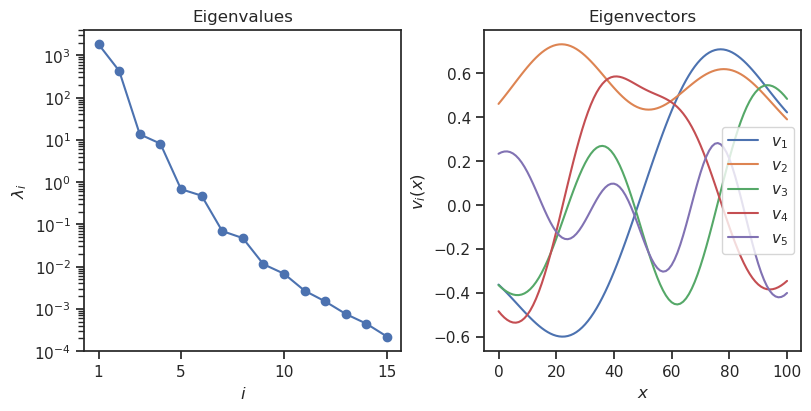

In [12]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].semilogy(index_vector, eigenvalues, marker="o")
axs[0].set_title("Eigenvalues")
axs[0].set_xticks((1, 5, 10, 15))
axs[0].set_xlabel(r"$i$")
axs[0].set_ylabel(r"$\lambda_i$")
for i in range(5):
    axs[1].plot(eigenvectors[i], label=f"$v_{i + 1}$")
axs[1].set_title("Eigenvectors")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$v_i(x)$")
axs[1].legend()

# Laplace Approximation

In [13]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=500
)

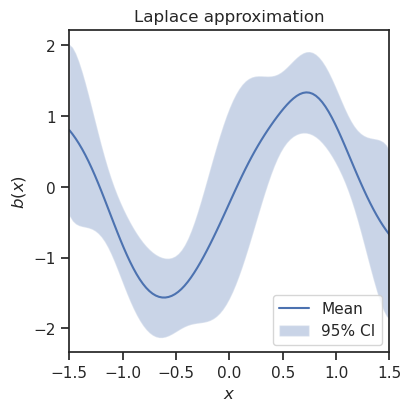

In [14]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, solver_solution.optimal_parameter, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter - 1.96 * np.sqrt(posterior_variance),
    solver_solution.optimal_parameter + 1.96 * np.sqrt(posterior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Laplace approximation")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.set_xlim((-1.5, 1.5))
ax.legend()